# Data process

- 데이터 읽고, shape 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

train_data = pd.read_csv("./data/kdd99_train.csv")
test_data = pd.read_csv("./data/kdd99_test.csv")
print(train_data.shape)
print(test_data.shape)


(395216, 42)
(98804, 42)


### train과 test에서 각각 공격 타입 횟수 결과 확인

In [2]:
print(train_data["Attack Type"].value_counts())
print(test_data["Attack Type"].value_counts())

Attack Type
dos       313104
normal     77911
probe       3273
r2l          891
u2r           37
Name: count, dtype: int64
Attack Type
dos       78354
normal    19366
probe       834
r2l         235
u2r          15
Name: count, dtype: int64


### train_data와 test데이터의 결측치 있는 샘플 확인

    - any(axis = 1) : 행 기준 True 하나라도 있으면 true.
    - df.isnull() : 각 요소마다 nan이면 true

In [3]:
print(train_data[train_data.isnull().any(axis = 1)])
print(test_data[test_data.isnull().any(axis = 1)])

Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, lnum_compromised, lroot_shell, lsu_attempted, lnum_root, lnum_file_creations, lnum_shells, lnum_access_files, lnum_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, Attack Type]
Index: []

[0 rows x 42 columns]
Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, lnum_compromised, lroot_shell, lsu_attempted, lnum_root, lnum_file_creations, lnum_shells, lnum_access_files, lnum_outbou

### train데이터에서 수치형 데이터가 아닌 데이터 찾기

In [4]:
num_cols = train_data._get_numeric_data().columns
cate_cols = list(set(train_data.columns) - set(num_cols))
cate_cols.remove('Attack Type')
cate_cols

['protocol_type', 'flag', 'service']

(1)데이터 문제형식 제거 (one - hot encoding)

위에서 찾은 문자열 데이터 수치형으로 변환

In [5]:
train_data = pd.get_dummies(train_data, columns = ['protocol_type','service', 'flag'], dtype = int)
test_data = pd.get_dummies(test_data, columns = ['protocol_type','service', 'flag'], dtype = int)
print(train_data)

        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        316        343     0               0       0    0   
1              0       1032          0     0               0       0    0   
2              0          0          0     0               0       0    0   
3              0          0          0     0               0       0    0   
4              0          0          0     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
395211         0       1032          0     0               0       0    0   
395212         0          0          0     0               0       0    0   
395213         0       1032          0     0               0       0    0   
395214      9141        147        105     0               0       0    0   
395215         0          0          0     0               0       0    0   

        num_failed_logins  logged_in  lnum_compromised  ...  flag_REJ  \
0 

(2) 공격 타입을 0과 1로 구분.

공격이면 0, 정상이면 1

In [6]:
train_data["Attack Type"] = (train_data["Attack Type"] == 'normal').astype(int)
test_data["Attack Type"] = (test_data["Attack Type"] == 'normal').astype(int)
print(train_data["Attack Type"])
print(test_data["Attack Type"])

0         1
1         0
2         0
3         0
4         0
         ..
395211    0
395212    0
395213    0
395214    1
395215    0
Name: Attack Type, Length: 395216, dtype: int64
0        0
1        0
2        0
3        1
4        0
        ..
98799    0
98800    0
98801    1
98802    1
98803    0
Name: Attack Type, Length: 98804, dtype: int64


컬럼별로 문자열로 되어있는 index 존재하는지 최종확인

(attack type과 feature의 숫자 변환 성공 확인)

In [7]:
string_cols = train_data.select_dtypes(include = "object").columns
string_cols2 = test_data.select_dtypes(include = "object").columns
print((string_cols, string_cols2))

(Index([], dtype='object'), Index([], dtype='object'))


(3) 데이터 중복 제거 & 결측치 제거

reset_index를 통해 다시 0 부터 정렬

(중복 확인은 df[df.duplicated()], df.duplicated는 중복된 열 반환) 

In [8]:
train_data = train_data.dropna().drop_duplicates().reset_index(drop=True)
test_data = test_data.dropna().drop_duplicates().reset_index(drop=True)

print(train_data.shape, test_data.shape)

(120174, 118) (35371, 116)


### 정답데이터와 feature 행렬 구분

In [9]:
x_train = train_data.drop(columns = ["Attack Type"])
y_train = train_data['Attack Type']
x_test = test_data.drop(columns = ["Attack Type"])
y_test = test_data["Attack Type"]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(120174, 117) (120174,)
(35371, 115) (35371,)


x_train과 x_test의 크기가 맞아야 연산 가능하기때문에 크기 맞춰주기.

df.align() - 두 df에 대해 열 순서 갯수를 맞춰주는 역할.

In [10]:
x_train, x_test = x_train.align(x_test, join='outer', axis=1, fill_value=0)
print(x_train.shape, x_test.shape)

(120174, 118) (35371, 118)


## pearson(x, y)

중복데이터를 제거하기위해 의미없는 특징(값이 모두 같은) 제거후 상관계수 계산 및 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

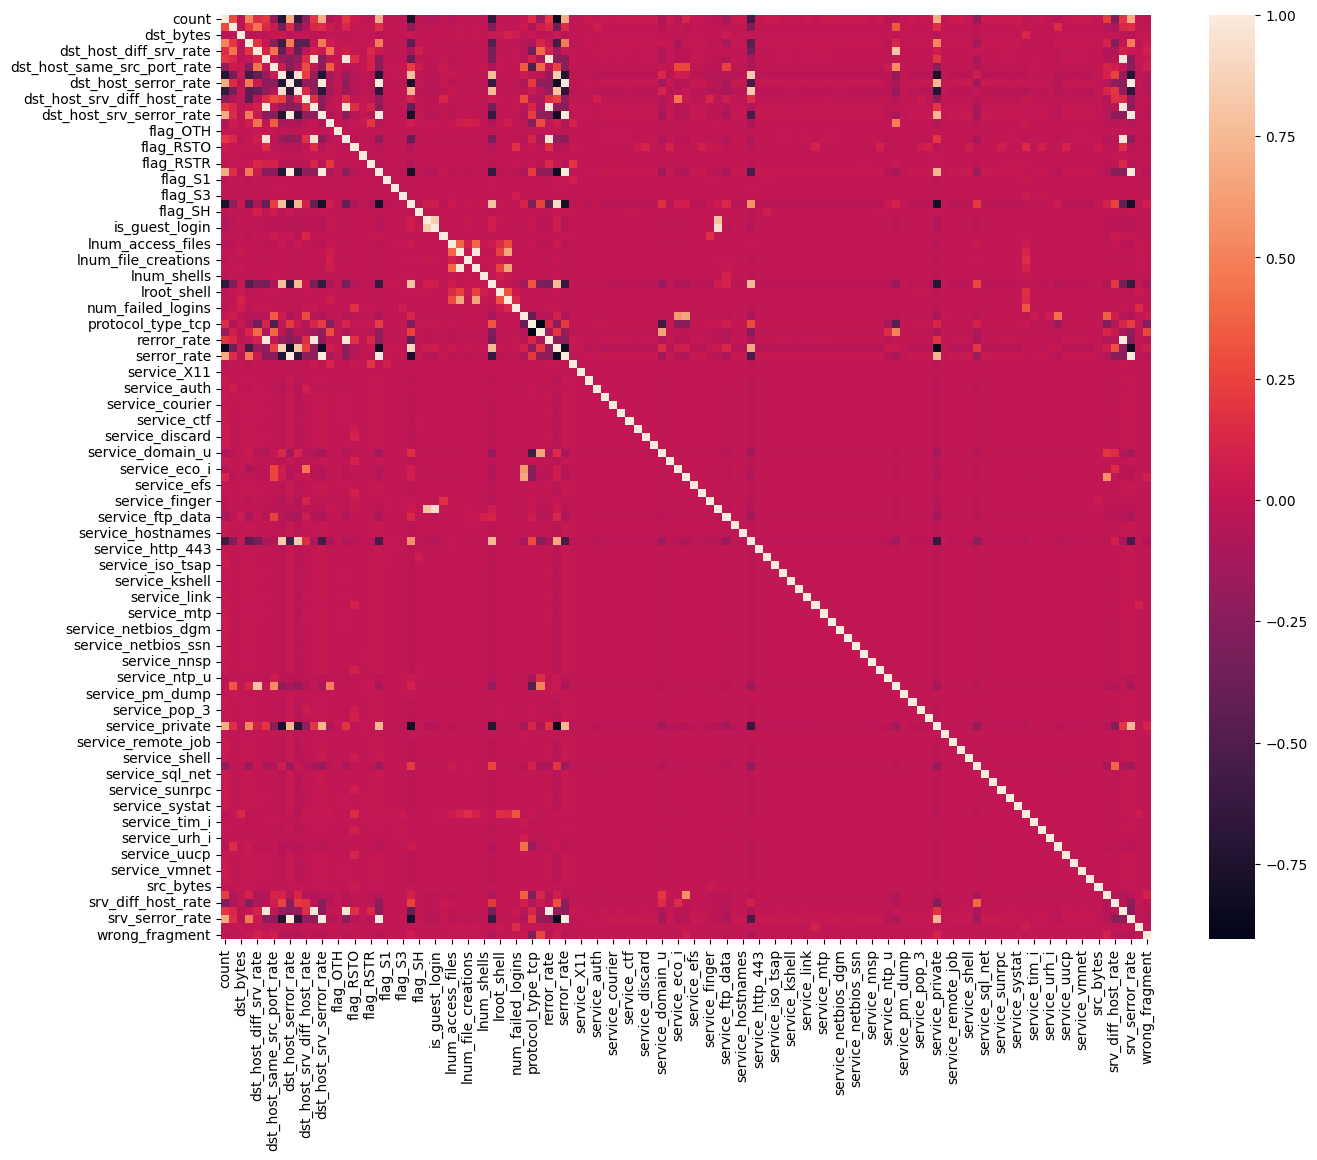

In [11]:
x_train = x_train.loc[:, x_train.nunique() > 1]
x_test = x_test[x_train.columns]
corr = x_train.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr)
plt.show

In [12]:
from mycode import *

data = Data()
drop = data.pearson(x_train)
print(x_train.shape, drop.shape) #13개의 열 중복으로 삭제

remove feature:  {'same_srv_rate', 'protocol_type_udp', 'flag_REJ', 'dst_host_srv_serror_rate', 'is_guest_login', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'serror_rate', 'dst_host_same_srv_rate', 'lnum_compromised', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate'}
13
(120174, 115) (120174, 102)


# 분석기 평가 및 비교

## Naive Baysian

In [13]:
from mycode import *

bays = baysian()
mean_y1, std_y1, mean_y0 , std_y0 = bays.condition_p(x_train, y_train)
print(mean_y1.shape, std_y1.shape, mean_y0.shape , std_y0.shape)
y_hat = bays.predict(x_train, y_train, x_test)
print(y_hat.shape)
print(y_hat)

(115,) (115,) (115,) (115,)
(35371,)
[1 1 1 ... 1 1 1]


In [16]:
evaluate = eval()
acc, prec, rec, f1 = evaluate.metrics_np(y_test, y_hat)
print("Accurate: ", acc,"\nPrecison: " , prec,"\nrecall: ", rec,"\nf1_score: ", f1)

Accurate:  0.5127929659890856 
Precison:  0.5127929659890856 
recall:  0.9999999999999946 
f1_score:  0.6779420283989968


In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = GaussianNB()

model.fit(x_train, y_train)

y_hat_sklearn = model.predict(x_test)

acc, prec, rec, f1 = evaluate.metrics_np(y_test, y_hat_sklearn)
print("Accurate: ", acc,"\nPrecison: " , prec,"\nrecall: ", rec,"\nf1_score: ", f1)


Accurate:  0.7687371010149535 
Precison:  0.6898787277858262 
recall:  0.9973536222295679 
f1_score:  0.8155996392663548
